# Make toy data

## Type 1. Independent Gaussian

$$
(x_1, x_2) \sim \mathcal{N}(0,I)
$$

## Type 2. Correlated Gaussian

$$
(y_1, y_2) \sim \mathcal{N}(0,\begin{bmatrix}1&\rho\\ \rho&1\end{bmatrix})
$$

In [1]:
import numpy as np

In [2]:
x = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0],[0,1]],
                                 size = 300)

In [3]:
y = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,0.8],[0.8,1]],
                                 size = 300)

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

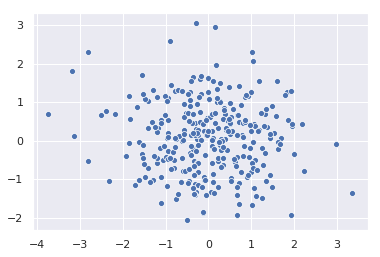

In [5]:
# plt indep Gaussian
sns.scatterplot(x=x[:,0],y=x[:,1])

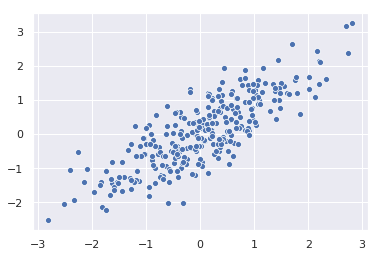

In [6]:
# plt cor Gaussian
sns.scatterplot(x=y[:,0],y=y[:,1])

# Define MINE

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd

In [8]:
class Mine(nn.Module):
    def __init__(self, input_size=2, hidden_size=100):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.relu(self.fc1(input))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

In [9]:
def mutual_information(joint, marginal, mine_net):
    t = mine_net(joint)
    et = torch.exp(mine_net(marginal))
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine(batch, mine_net, mine_net_optim,  ma_et, ma_rate=0.11):
    # batch is a tuple of (joint, marginal)
    joint , marginal = batch
    joint = torch.autograd.Variable(torch.FloatTensor(joint))
    marginal = torch.autograd.Variable(torch.FloatTensor(marginal))
    mi_lb , t, et = mutual_information(joint, marginal, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    loss = -(torch.mean(t) - (et.mean()/ma_et.mean()).detach()*torch.log(torch.mean(et)))
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et

In [10]:
def sample_batch(data, batch_size=32, sample_mode='joint'):
    if sample_mode == 'joint':
        index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = data[index]
    else:
        joint_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        marginal_index = np.random.choice(range(data.shape[0]), size=batch_size, replace=False)
        batch = np.concatenate([data[joint_index][:,0].reshape(-1,1),
                                         data[marginal_index][:,1].reshape(-1,1)],
                                       axis=1)
    return batch

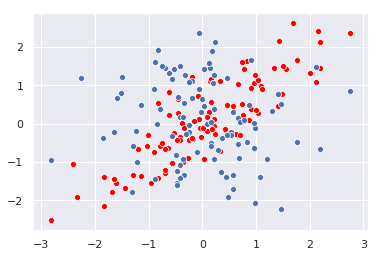

In [11]:
joint_data = sample_batch(y,batch_size=100,sample_mode='joint')
sns.scatterplot(x=joint_data[:,0],y=joint_data[:,1],color='red')
marginal_data = sample_batch(y,batch_size=100,sample_mode='marginal')
sns.scatterplot(x=marginal_data[:,0],y=marginal_data[:,1])

In [12]:
def train(data, mine_net,mine_net_optim, batch_size=32, iter_num=int(1e+4), log_freq=1e+3):
    # data is x or y
    result = list()
    ma_et = 1.
    for i in range(iter_num):
        batch = sample_batch(data,batch_size=batch_size)\
        , sample_batch(data,batch_size=batch_size,sample_mode='marginal')
        mi_lb, ma_et = learn_mine(batch, mine_net, mine_net_optim, ma_et)
        ma_et = ma_et.detach()
        result.append(mi_lb.data.numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result

In [13]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]

In [14]:
mine_net_indep = Mine()
mine_net_optim_indep = optim.Adam(mine_net_indep.parameters(), lr=1e-4)
result_indep = train(x,mine_net_indep,mine_net_optim_indep)

0.0011845224
-0.003932734
0.005391105
-0.002427346
0.008352283
0.026819687
-0.0023866966
0.020917471
0.012880892
0.023904465


0.015751384


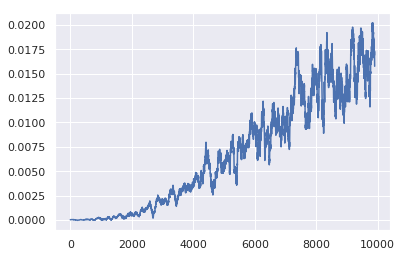

In [15]:
result_indep_ma = ma(result_indep)
print(result_indep_ma[-1])
plt.plot(range(len(result_indep_ma)),result_indep_ma)

In [16]:
mine_net_cor = Mine()
mine_net_optim_cor = optim.Adam(mine_net_cor.parameters(), lr=1e-4)
result_cor = train(y,mine_net_cor,mine_net_optim_cor)

0.4480867
0.48215505
0.6698849
0.8153494
0.29019782
0.71071756
0.0896146
0.7249654
0.89569813
0.544641


0.6103169


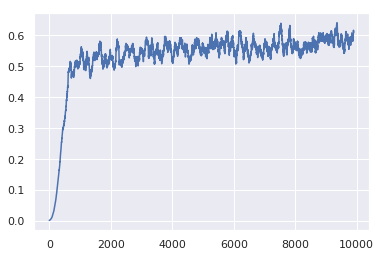

In [17]:
result_cor_ma = ma(result_cor)
print(result_cor_ma[-1])
plt.plot(range(len(result_cor_ma)),result_cor_ma)

# Test with various correlations

In [18]:
correlations = np.linspace(-0.9,0.9,19)
print(correlations)

[-0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4
  0.5  0.6  0.7  0.8  0.9]


1.0355798
1.1986063
1.5372744
0.66980016
1.2940394
0.6366077
1.44704
1.0115459
0.39810634
0.524371
-0.9 : 1.0308316
0.52168554
0.69302243
0.43963355
0.39009228
-0.014756918
0.6953926
0.7074949
0.4203063
0.30784088
0.50139374
-0.8 : 0.46910495
0.40096486
0.005423248
0.4148388
0.12692541
0.49540135
0.328588
0.1689724
0.45182925
0.47656125
0.3137527
-0.7 : 0.38235545
0.21024638
0.31726098
0.27762473
0.159296
0.18143086
0.15620819
0.28785712
0.18957102
0.2847678
0.27953032
-0.6 : 0.21688303
0.21478365
0.60617465
0.2795232
0.16942856
-0.0154064745
0.06875849
0.3165414
-0.07526986
0.3157103
0.3663677
-0.5 : 0.16910022
-0.0041130856
0.24464503
0.14131801
-0.012154102
0.1913753
0.15305558
0.16876842
0.08744839
0.011230856
0.22735755
-0.4 : 0.08735671
-0.035865087
0.07514919
0.030579558
-0.047365326
0.03245315
0.05088872
0.04951504
0.011698141
-0.093153745
0.07837968
-0.29999999999999993 : 0.0647068
0.00524012
-0.0030724965
0.027187686
0.05214681
-0.0085813925
-0.008395832
-0.017595313
-0.06327

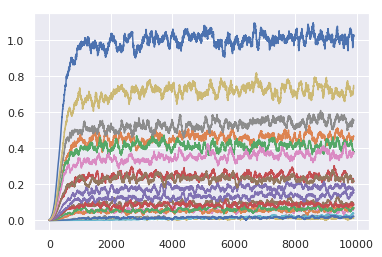

In [19]:
final_result = []
for rho in correlations:
    rho_data = np.random.multivariate_normal( mean=[0,0],
                                  cov=[[1,rho],[rho,1]],
                                 size = 300)
    mine_net = Mine()
    mine_net_optim = optim.Adam(mine_net.parameters(), lr=1e-4)
    result = train(rho_data,mine_net,mine_net_optim)
    result_ma = ma(result)
    final_result.append(result_ma[-1])
    print(str(rho) + ' : ' + str(final_result[-1]))
    plt.plot(range(len(result_ma)),result_ma)

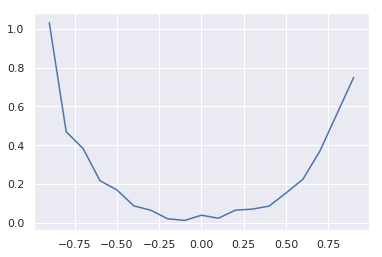

In [20]:
plt.plot(correlations, final_result)